# 3.1 Data Processing
In this exercise we will build a complete EO workflow using cloud provided data (STAC Catalogue), processing it locally; from data access to obtaining the result. In this example we will analyse snow cover in the Alps.

We are going to follow these steps in our analysis:

-   Load satellite collections
-   Specify the spatial, temporal extents and the features we are interested in
-   Process the satellite data to retrieve snow cover information
-   aggregate information in data cubes
-   Visualize and analyse the results

More information on the openEO Python Client: https://open-eo.github.io/openeo-python-client/index.html

More information on the Client Side Processing and `load_stac` functionalities: https://open-eo.github.io/openeo-python-client/cookbook/localprocessing.html

## Install missing and update packages:

In [1]:
%%capture
pip install rioxarray geopandas leafmap

In [2]:
%%capture
pip install openeo[localprocessing] --upgrade

## Libraries

In [3]:
# platform libraries
from openeo.local import LocalConnection

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


## Region of Interest

Load the catchment area.

In [5]:
catchment_outline = gpd.read_file('../31_data/catchment_outline.geojson')

In [7]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('../31_data/catchment_outline.geojson', layer_name="catchment")
m

## Inspect STAC Metadata
We need to set the following configurations to define the content of the data cube we want to access:
- STAC Collection URL
- band names
- time range
- the area of interest specifed via bounding box coordinates

We use the Sentinel-2 L2A Collection from Microsoft: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a

## Define a workflow
We will define our workflow now. And chain all the processes together we need for analyzing the snow cover in the catchment.

### Define the data cube
We define all extents of our data cube. We use the catchment as spatial extent. As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018.

In [8]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

We know that the catchment area is almost fully covered by the Sentinel-2 32TPS tile and therefore we use this information in the properties filter, along with a first filter on the cloud coverage.

In [9]:
local_conn = LocalConnection("./")

url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a"
spatial_extent  = {"west":bbox[0],"east":bbox[2],"south":bbox[1],"north":bbox[3]}
temporal_extent = ["2018-02-01", "2018-06-30"]

bands_11_scl    = ["B11", "SCL"]
band_03        = ["B03"]

properties = {"eo:cloud_cover": dict(lt=75),
              "s2:mgrs_tile": dict(eq="32TPS")}

### Load the data cube
We have defined the extents we are interested in. Now we use these definitions to load the data cube.

Since the B03 band have resolution of 10m and B11 and SCL 20m, we load them separately and then align in a second step using openEO.

In [10]:
s2_B11_SCL = local_conn.load_stac(
    url=url,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=bands_11_scl,
    properties=properties,
)

In [11]:
s2_B03 = local_conn.load_stac(
    url=url,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=band_03,
    properties=properties,
)

Uncomment the content of the next three cells if you would like to download the data first and then use the netCDFs to proceed.

It will download ~3 GB of data, make sure to have enough free space.

In [ ]:
# %%time
# s2_11_scl_xr = s2_B11_SCL.execute()
# # Remove problematic attributes and coordinates, which prevent to write a valid netCDF file
# for at in s2_11_scl_xr.attrs:
#     # allowed types: str, Number, ndarray, number, list, tuple
#     if not isinstance(s2_11_scl_xr.attrs[at], (int, float, str, np.ndarray, list, tuple)):
#         s2_11_scl_xr.attrs[at] = str(s2_11_scl_xr.attrs[at])

# for c in s2_11_scl_xr.coords:
#     if s2_11_scl_xr[c].dtype=="object":
#         s2_11_scl_xr = s2_11_scl_xr.drop_vars(c)

# s2_11_scl_xr.to_dataset(dim="band").to_netcdf("s2_11_scl_xr.nc")

In [12]:
# %%time
# s2_03_xr = s2_B03.execute()
# # Remove problematic attributes and coordinates, which prevent to write a valid netCDF file
# for at in s2_03_xr.attrs:
#     # allowed types: str, Number, ndarray, number, list, tuple
#     if not isinstance(s2_03_xr.attrs[at], (int, float, str, np.ndarray, list, tuple)):
#         s2_03_xr.attrs[at] = str(s2_03_xr.attrs[at])

# for c in s2_03_xr.coords:
#     if s2_03_xr[c].dtype=="object":
#         s2_03_xr = s2_03_xr.drop_vars(c)

# s2_03_xr.to_dataset(dim="band").to_netcdf("s2_03_xr.nc")

In [7]:
# s2_B03 = local_conn.load_collection("s2_03_xr.nc")
# s2_B11_SCL = local_conn.load_collection("s2_11_scl_xr.nc")

In [12]:
s2_20m = s2_B03.resample_cube_spatial(target=s2_B11_SCL,method="average").merge_cubes(s2_B11_SCL)

### NDSI - Normalized Difference Snow Index
The Normalized Difference Snow Index (NDSI) is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We have created a Sentinel-2 data cube with bands B03 (green), B11 (SWIR) and the scene classification mask (SCL). We will use the green and SWIR band to calculate a the NDSI. This process is reducing the band dimension of the data cube to generate new information, the NDSI.

In [13]:
green = s2_20m.band("B03")
swir = s2_20m.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

### Creating the Snow Map
So far we have a timeseries of NDSI values. We are intereseted in the presence of snow though. Ideally in a binary classification: snow and no snow.
To achieve this we are setting a threshold of 0.42 on the NDSI. This gives us a binary snow map.

In [14]:
ndsi_mask = ( ndsi > 0.42 )
snowmap = ndsi_mask.add_dimension(name="band",label="snow_map",type="bands")
snowmap

### Creating a cloud mask
We are going to use "SCL" band for creating a cloud mask and then applying it to the NDSI. 
`8 = cloud medium probability`, `9 = cloud high probability`, `3 = cloud shadow`

Here is more information on the Scene Classification https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview

| Value        | Label    |
|--------------|-----------|
| 0	    | NO_DATA                  |
| 1	    | SATURATED_OR_DEFECTIVE   |
| 2	    | CAST_SHADOWS             |
| 3	    | CLOUD_SHADOWS            |
| 4	    | VEGETATION               |
| 5	    | NOT_VEGETATED            |
| 6	    | WATER 	    	       |
| 7	    | UNCLASSIFIED 	           |
| 8	    | CLOUD_MEDIUM_PROBABILITY |
| 9	    | CLOUD_HIGH_PROBABILITY   |
| 10	| THIN_CIRRUS              |
| 11	| SNOW or ICE              |

In [15]:
scl_band = s2_20m.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ).add_dimension(name="band",label="cloud_mask",type="bands")
cloud_mask

### Applying the cloud mask to the snowmap
We will mask out all pixels that are covered by clouds. This will result in: 0 = no_snow, 1 = snow, 2 = cloud

In [16]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

### Visualize one time step of the timeseries
Let's create the lazy xarray view of the result and look how our first results look like

In [17]:
snowmap_cloudfree_1d = snowmap_cloudfree.filter_temporal('2018-02-10', '2018-02-12').mask_polygon(catchment_outline["geometry"][0])
snowmap_cloudfree_1d_xr = snowmap_cloudfree_1d.execute()

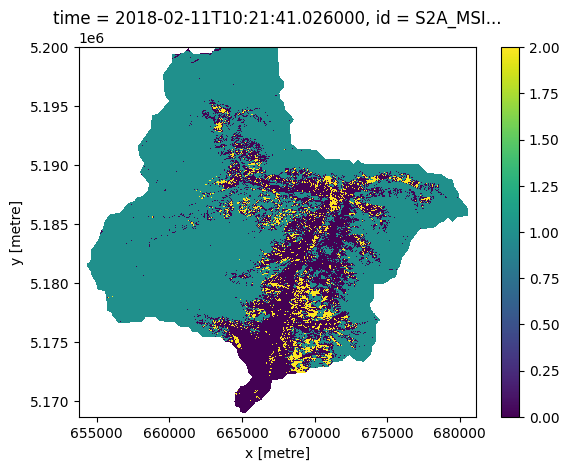

In [18]:
snowmap_cloudfree_1d_xr[0,0].plot.imshow()

## Calculate Catchment Statistics

We are looking at a region over time. We need to make sure that the information content meets our expected quality. Therefore, we calculate the **cloud percentage** for the catchment for each timestep. We use this information to filter the timeseries. All timesteps that have a cloud coverage of over 25% will be discarded.

Ultimately we are interested in the **snow covered area (SCA)** within the catchment. We count all snow covered pixels within the catchment for each time step. Multiplied by the pixel size that would be the snow covered area. Divided the pixel count by the total number of pixels in the catchment is the percentage of pixels covered with snow. We will use this number.

Get number of pixels in catchment: total, clouds, snow.

In [19]:
snow_cloud_map_0 = (snowmap_cloudfree == 1).merge_cubes(cloud_mask)
snow_cloud_map = (ndsi_mask > -1).add_dimension(name="band",label="valid_px",type="bands").merge_cubes(snow_cloud_map_0)

Aggregate to catchment using the `aggregate_spatial` process.

In [29]:
snow_cloud_map_timeseries = snow_cloud_map.aggregate_spatial(geometries=catchment_outline["geometry"][0],reducer="sum")
snow_cloud_map_timeseries

Get the result as a Dask based xArray object

In [30]:
snow_cloud_map_timeseries_xr = snow_cloud_map_timeseries.execute()
snow_cloud_map_timeseries_xr

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


<xarray.DataArray (geometry: 1, band: 3, time: 32)> Size: 768B
dask.array<broadcast_to, shape=(1, 3, 32), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 256B 2018-...
  * band                                     (band) <U10 120B 'valid_px' ... ...
    id                                       (time) <U54 7kB 'S2A_MSIL2A_2018...
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    s2:nodata_pixel_percentage               (time) float64 256B 0.0 ... 11.05
    ...                                       ...
    common_name                              <U5 20B 'green'
    center_wavelength                        float64 8B 0.56
    full_width_half_max                      float64 8B 0.045
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0
  * geometry                                 (geometry) object 8B POLYGON ((6...
Indexes:
    geometry  GeometryIndex (crs=EPSG:32632)
Attributes:
    crs:                            epsg:32632
    reduced_dimensions_min_values:  {'band': 'B03'}

Compute the result. Please note, this will trigger the download and processing of the requested data.

In [31]:
snow_cloud_map_timeseries_xr = snow_cloud_map_timeseries_xr.compute()

In [32]:
snow_cloud_map_timeseries_xr

<xarray.DataArray (geometry: 1, band: 3, time: 32)> Size: 768B
array([[[1039875., 1039875., 1039875., 1039875., 1039875., 1039875.,
         1039875., 1039875., 1039875., 1039875., 1039875., 1039875.,
         1039875., 1039875., 1039875., 1039875., 1039875., 1039875.,
         1039875., 1039875., 1039875., 1039875., 1039875., 1039875.,
         1039875., 1039875., 1039875., 1039875., 1039875., 1039875.,
         1039875., 1039875.],
        [ 721108.,  746324.,  505519.,  666087.,  574287.,  717432.,
          181569.,  341945.,  447801.,  276157.,  683636.,  444741.,
          737500.,  589989.,  449066.,  113861.,  689327.,  654874.,
          670597.,  553375.,  576242.,  535398.,  428109.,  173667.,
           65467.,   11728.,    2120.,   59170.,   20304.,   16569.,
           33761.,   13923.],
        [  43282.,   50500.,  265340.,   99748.,  190841.,   60625.,
          678521.,  456600.,  320558.,  656121.,  200369.,  525781.,
           66535.,  170522.,  268273.,  877061.,   23772.,   49337.,
           58783.,  171374.,   27758.,   27322.,  155250.,  518898.,
          558722.,  676188.,  912866.,   27335.,  472718.,  403790.,
           25324.,  248254.]]])
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 256B 2018-...
  * band                                     (band) <U10 120B 'valid_px' ... ...
    id                                       (time) <U54 7kB 'S2A_MSIL2A_2018...
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    s2:nodata_pixel_percentage               (time) float64 256B 0.0 ... 11.05
    ...                                       ...
    common_name                              <U5 20B 'green'
    center_wavelength                        float64 8B 0.56
    full_width_half_max                      float64 8B 0.045
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0
  * geometry                                 (geometry) object 8B POLYGON ((6...
Indexes:
    geometry  GeometryIndex (crs=EPSG:32632)
Attributes:
    crs:                            epsg:32632
    reduced_dimensions_min_values:  {'band': 'B03'}

Plot the timeseries and the cloud threshold of 25%. If the cloud cover is higher the timestep will be excluded later on.

Plot the **cloud percentage** with the threshold.s

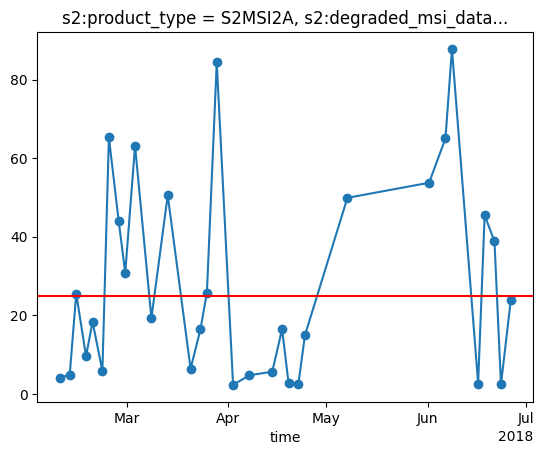

In [33]:
cloud_percent = (snow_cloud_map_timeseries_xr.loc[dict(band="cloud_mask")] / snow_cloud_map_timeseries_xr.loc[dict(band="valid_px")]) * 100
cloud_percent.plot(marker='o')
# plot the cloud percentage and a threshold
plt.axhline(y = 25, color = "r", linestyle = "-")
plt.show()

Plot the **unfiltered snow percentage**

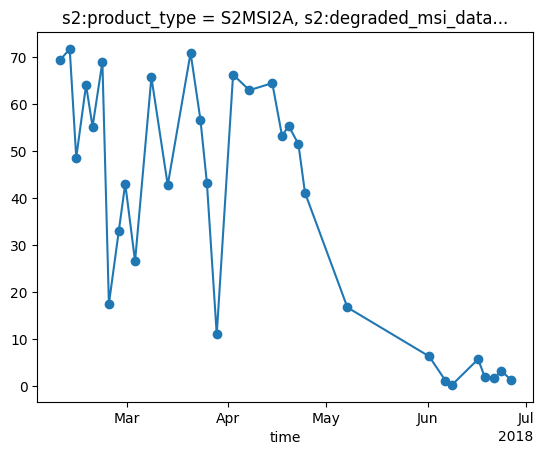

In [34]:
snow_percent = (snow_cloud_map_timeseries_xr.loc[dict(band="snow_map")] / snow_cloud_map_timeseries_xr.loc[dict(band="valid_px")]) * 100
snow_percent.plot(marker='o')
plt.show()

Keep only the dates with cloud coverage less than the threshold

In [35]:
snow_percent = snow_percent.where(cloud_percent<25,drop=True)

Plot the **cloud filtered snow percentage**

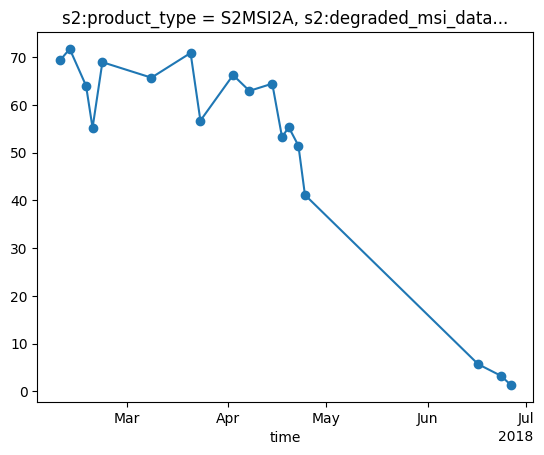

In [36]:
snow_percent.plot(marker='o')
plt.show()

## Compare to discharge data

Load the discharge data at Meran. The main outlet of the catchment.

In [40]:
discharge_ds = pd.read_csv('../../../3.2_validation/3.2_exercises/32_data/ADO_DSC_ITH1_0025.csv', sep=',', index_col='Time', parse_dates=True)
discharge_ds.head()

,discharge_m3_s
Time,
1994-01-01 01:00:00,4.03
1994-01-02 01:00:00,3.84
1994-01-03 01:00:00,3.74
1994-01-04 01:00:00,3.89
1994-01-05 01:00:00,3.80


Compare the discharge data to the snow covered area.

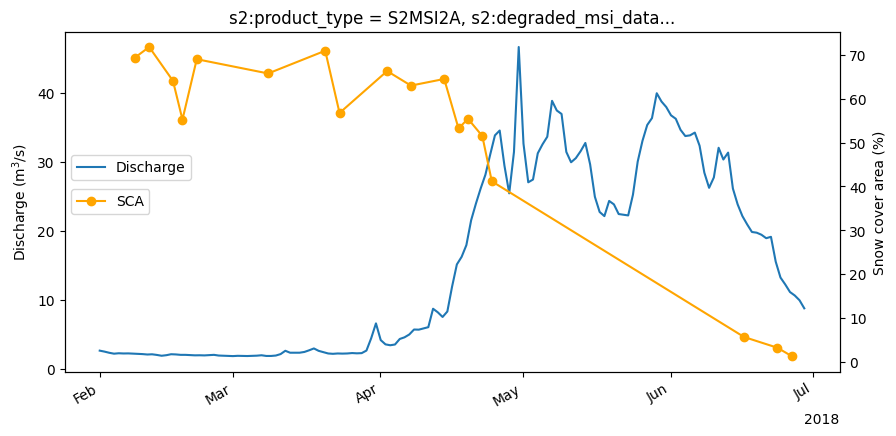

In [41]:
fig,ax0 = plt.subplots(1, figsize=(10,5),sharey=True)
ax1 = ax0.twinx() 

start_date = date(2018, 2, 1)
end_date = date(2018, 6, 30)
# filter discharge data to start and end dates
discharge_ds = discharge_ds.loc[start_date:end_date]

discharge_ds.discharge_m3_s.plot(label='Discharge', xlabel='', ylabel='Discharge (m$^3$/s)',ax=ax0)
snow_percent.plot(marker='o',ax=ax1,color='orange')
ax0.legend(loc='center left', bbox_to_anchor=(0, 0.6))
ax1.set_ylabel('Snow cover area (%)')
ax1.legend(loc='center left', bbox_to_anchor=(0, 0.5),labels=['SCA'])
plt.show()